# StyleGAN


This [StyleGAN](https://arxiv.org/abs/1812.04948) implementation is based on the book [Hands-on Image Generation with TensorFlow](https://www.amazon.com/dp/1838826785). The code from the book's [Github repository](https://github.com/PacktPublishing/Hands-On-Image-Generation-with-TensorFlow-2.0/tree/master/Chapter07) is refactored into custom train step to enable faster training time in non-eager mode. The key features of StyleGAN is to grow the resolution progressively and to incorporate style features in the generative process.

## Import modules

In [1]:
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from glob import glob
from functools import partial

import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Input, LeakyReLU, Reshape
from tensorflow.keras.layers import UpSampling2D, AveragePooling2D, Flatten
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow_addons.layers import InstanceNormalization

In [2]:
"""invisible"""
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[2], True)
tf.config.experimental.set_visible_devices(gpus[2], 'GPU')
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")

4 Physical GPUs, 1 Logical GPU


## Prepare Dataset
In this examples, we wiil use CelebA pre-resized to 64x64 resolution.

In [12]:
CKPT_PATH = './ckpt/64x64'
DATA_PATH = "celeba_64x64/*.jpg"
RESULT_PATH = './results'
os.makedirs(CKPT_PATH, exist_ok=True)
os.makedirs(RESULT_PATH, exist_ok=True)

In [14]:
"""shell
curl -LO https://github.com/soon-yau/stylegan_keras/releases/download/keras_example/celeba_64x64.zip
unzip celeba_64x64.zip -d .
"""

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   624  100   624    0     0   2823      0 --:--:-- --:--:-- --:--:--  2823
100 29.6M  100 29.6M    0     0  7685k      0  0:00:03  0:00:03 --:--:-- 8648k
Archive:  celeba_64x64.zip
replace ./celeba_64x64/f076710.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


We use different batch size for different image resolution, with small batch size for high resolution so they fit into GPU memory. The training steps are scaled accordingly.

In [15]:
BATCH_SIZE = {2: 16, 3: 16, 4: 16, 5: 16, 6: 16, 7: 8, 8: 4, 9: 4, 10:4}
TRAIN_STEP_RATIO = {k: BATCH_SIZE[2]/v for k, v in BATCH_SIZE.items()}

def load(res, image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, [res, res],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.cast(image, tf.float32)
    image = (image /127.5) - 1
    return image

def create_dataset_(data_path, res):
    res_log2 = int(np.log2(res))
    BUFFER_SIZE = 100
    images = glob(data_path)
    random.shuffle(images)
    batch_size = BATCH_SIZE[res_log2]
    tf_list = tf.data.Dataset.from_tensor_slices(images)
    dataset = tf_list.map(partial(load, res),  num_parallel_calls= tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE).batch(batch_size, drop_remainder=True).repeat()
    return dataset


create_dataset = partial(create_dataset_, DATA_PATH)
    

### Utility function to display images after each epoch

In [7]:
def plot_images(images, log2_res, fname=''):    
    scales = {2:0.5,
             3:1,
             4:2,
             5:3,
             6:4,
             7:5,
             8:6,
             9:7,
             10:8}
    scale = 0.5*scales[log2_res]
    
    grid_col = min(images.shape[0], int(16//scale))
    grid_row = 1

    f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*scale, grid_row*scale))

    for row in range(grid_row):
        ax = axarr if grid_row==1 else axarr[row]
        for col in range(grid_col):
            ax[col].imshow(images[row*grid_col + col])
            ax[col].axis('off')
    plt.show()
    if fname:
        f.savefig(fname)

## Custom Layers
The following are building blocks that will be used to construct the generators and discriminators.

In [8]:
def fade_in(alpha, a, b):
    
    return alpha * a + (1. - alpha) * b

def wasserstein_loss(y_true, y_pred):
    
    return -tf.reduce_mean(y_true * y_pred)

class PixelNorm(Layer):
    def __init__(self, epsilon=1e-8):
        super(PixelNorm, self).__init__()
        self.epsilon = epsilon
        
    def call(self, input_tensor):
        return input_tensor / tf.math.sqrt(tf.reduce_mean(input_tensor**2, axis=-1, keepdims=True) + self.epsilon)


class MinibatchStd(Layer): 
    def __init__(self, group_size=4, epsilon=1e-8): 

        super(MinibatchStd, self).__init__() 
        self.epsilon = epsilon 
        self.group_size = group_size 
        
    def call(self, input_tensor): 

        n, h, w, c = input_tensor.shape 
        x = tf.reshape(input_tensor, [self.group_size, -1, h, w, c]) 
        group_mean, group_var = tf.nn.moments(x, axes=(0), keepdims=False) 
        group_std = tf.sqrt(group_var + self.epsilon) 
        avg_std = tf.reduce_mean(group_std, axis=[1,2,3], keepdims=True) 
        x = tf.tile(avg_std, [self.group_size, h, w, 1]) 

        return tf.concat([input_tensor, x], axis=-1) 
    

class ConvBlock(Layer):
    def __init__(self, out_channels, kernel=3, gain=2, **kwargs):
        super(ConvBlock, self).__init__(kwargs)
        self.kernel = kernel
        self.out_channels = out_channels
        self.gain = gain
        self.pad = kernel!=1
        
    def build(self, input_shape):
        self.in_channels = input_shape[-1]

        initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)        
        self.w = self.add_weight(shape=[self.kernel,
                                        self.kernel,
                                        self.in_channels,
                                        self.out_channels],
                                initializer=initializer,
                                trainable=True, name='kernel')
        
        self.b = self.add_weight(shape=(self.out_channels,),
                                initializer='zeros',
                                trainable=True, name='bias')
        
        fan_in = self.kernel*self.kernel*self.in_channels
        self.scale = tf.sqrt(self.gain/fan_in)
        
    def call(self, inputs):
        if self.pad:
            x = tf.pad(inputs, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        else:
            x = inputs
        output = tf.nn.conv2d(x, self.scale*self.w, strides=1, padding="VALID") + self.b
        return output
    
class DenseBlock(Layer):
    def __init__(self, units, gain=2, lrmul=1, **kwargs):
        super(DenseBlock, self).__init__(kwargs)
        self.units = units
        self.gain = gain
        self.lrmul = lrmul
        
    def build(self, input_shape):
        self.in_channels = input_shape[-1]
        initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1./self.lrmul)        
        self.w = self.add_weight(shape=[self.in_channels,
                                        self.units],
                                initializer=initializer,
                                trainable=True, name='kernel')
        
        self.b = self.add_weight(shape=(self.units,),
                                initializer='zeros',
                                trainable=True, name='bias')
        
        fan_in = self.in_channels
        self.scale = tf.sqrt(self.gain/fan_in)
        
    @tf.function(experimental_relax_shapes=True)
    def call(self, inputs):
        output = tf.add(tf.matmul(inputs, self.scale*self.w), self.b)
        return output*self.lrmul
    
    
class AddNoise(Layer):
        
    def build(self, input_shape):
        n, h, w, c = input_shape[0]

        initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
        self.B = self.add_weight(shape=[1, 1, 1, c],
                                initializer=initializer,
                                trainable=True, name='kernel')
        
    def call(self, inputs):
        x, noise = inputs
        output = x + self.B * noise
        return output


class AdaIN(Layer):
    def __init__(self, gain=1, **kwargs):
        super(AdaIN, self).__init__(kwargs)
        self.gain = gain
        
    def build(self, input_shapes):
        x_shape = input_shapes[0]
        w_shape = input_shapes[1]

        self.w_channels = w_shape[-1]
        self.x_channels = x_shape[-1]
        
        self.dense_1 = DenseBlock(self.x_channels, gain=1)
        self.dense_2 = DenseBlock(self.x_channels, gain=1)
        
    @tf.function(experimental_relax_shapes=True)        
    def call(self, inputs):
        x, w = inputs
        ys = tf.reshape(self.dense_1(w), (-1, 1, 1, self.x_channels))
        yb = tf.reshape(self.dense_2(w), (-1, 1, 1, self.x_channels))
        
        output = ys*x + yb
        return output    

We create functions to build generators and discriminators at different resolution e.g. from 4x4, 8x8,... to 1024x1024.

In [9]:
def Mapping(num_stages, input_shape=512):
    z = Input(shape=(input_shape))
    w = PixelNorm()(z)
    for i in range(8):
        w = DenseBlock(512, lrmul=0.01)(w)
        w = LeakyReLU(0.2)(w)
    w = tf.tile(tf.expand_dims(w, 1), (1,num_stages,1))        
    return tf.keras.Model(z, w, name='mapping')    
   
    
def GenBlock(filter_num, res, input_shape, is_base):

    input_tensor = Input(shape=input_shape, name=f'g_{res}')
    noise = Input(shape=(res, res, 1), name=f'noise_{res}')
    w = Input(shape=512)
    
    x = input_tensor        

    if not is_base:
        x = UpSampling2D((2,2))(x)
        x = ConvBlock(filter_num, 3)(x)

    x = AddNoise()([x, noise])
    x = LeakyReLU(0.2)(x)
    x = InstanceNormalization()(x)
    x = AdaIN()([x, w])

    x = ConvBlock(filter_num, 3)(x)
    x = AddNoise()([x, noise])
    x = LeakyReLU(0.2)(x)
    x = InstanceNormalization()(x)      
    x = AdaIN()([x, w])

    return tf.keras.Model([input_tensor, w, noise], x, 
                 name=f'genblock_{res}x{res}')

def DiscBase(filter_num, res):
    return Sequential([Input(shape=(res, res, filter_num), name=f'd_{res}'),
                     MinibatchStd(),
                     ConvBlock(filter_num, 3),
                     LeakyReLU(0.2),
                     Flatten(),
                     Dense(filter_num),
                     LeakyReLU(0.2),
                     Dense(1)], name=f'd_{res}')      

def DiscBlock(filter_num_1, filter_num_2, res):
    return Sequential([Input(shape=(res, res, filter_num_1), name=f'd_{res}'),
                       ConvBlock(filter_num_1, 3),
                       LeakyReLU(0.2),
                       ConvBlock(filter_num_2, 3),
                       LeakyReLU(0.2),
                       AveragePooling2D((2,2))
                      ], name=f'd_{res}')


## Build StyleGAN with custom train step

In [10]:
class Phase(Enum):
    TRANSITION = 1
    STABLE = 2
    
class StyleGAN(tf.keras.Model):
    @staticmethod
    def log2(res):
        return int(np.log2(res))
    
    def __init__(self, z_dim=512, target_res=64, start_res=4):
        super(StyleGAN, self).__init__()
        self.z_dim = z_dim
        
        self.target_res_log2 = self.log2(target_res)
        self.start_res_log2 = self.log2(start_res)
        self.current_res_log2 = self.target_res_log2
        self.num_stages = self.target_res_log2 - self.start_res_log2 + 1
         
        self.filter_nums = {
            0: 512,
            1: 512,
            2: 512, # 4x4
            3: 512, # 8x8
            4: 512, # 16x16
            5: 512, # 32x32
            6: 256, # 64x64
            7: 128, # 128x128
            8: 64,  # 256x256
            9: 32,  # 512x512
            10: 16} # 1024x1024 
        
        self.g_input_shape = (start_res, start_res, self.filter_nums[self.start_res_log2])
        self.g_input = Input(self.g_input_shape)
        self.mapping = Mapping(num_stages=self.num_stages)
        self.build_generators()
        self.build_discriminators()

        self.phase = Phase.STABLE
        self.alpha = tf.Variable(1., dtype=tf.float32, trainable=False, name='alpha')
        self.train_step_counter = tf.Variable(0, dtype=tf.int32, trainable=False)
                      
        self.loss_weights = {'gradient_penalty':10, 'drift':0.001}

    
    def build_generators(self):
        
        self.to_rgb = []
        self.g_blocks = []
        self.noise_inputs = []
        for i in range(self.start_res_log2, self.target_res_log2 + 1):
            filter_num = self.filter_nums[i]
            res = 2**i
            self.noise_inputs.append(Input(shape=(res, res, 1), name=f'noise_{res}x{res}'))
            to_rgb = Sequential([Input(shape=(res, res, filter_num)),
                                 ConvBlock(3, 1, gain=1, activation=None)],
                                name=f'to_rgb_{res}x{res}')
            self.to_rgb.append(to_rgb)
            is_base = i==self.start_res_log2
            if is_base:
                input_shape = (res, res, self.filter_nums[i-1])
            else:
                input_shape = (2**(i-1), 2**(i-1), self.filter_nums[i-1])
            g_block = GenBlock(filter_num, res=res, 
                               input_shape=input_shape, is_base=is_base)
            self.g_blocks.append(g_block)

            

    def build_discriminators(self):
        self.from_rgb = []
        self.d_blocks = []
        
        for res_log2 in range(self.start_res_log2, self.target_res_log2 + 1):
            res = 2**res_log2
            filter_num = self.filter_nums[res_log2]
            from_rgb = Sequential([Input(shape=(res, res, 3), name=f'from_rgb_input_{res}'), 
                                    ConvBlock(filter_num, 1),
                                    LeakyReLU(0.2)], name=f'from_rgb_{res}')
            
            self.from_rgb.append(from_rgb)
            
            
            input_shape = (res, res, filter_num)
            if len(self.d_blocks) == 0:                
                d_block = DiscBase(filter_num, res)
            else:
                d_block = DiscBlock(filter_num, self.filter_nums[res_log2-1], res)
                
            self.d_blocks.append(d_block)
    
    def grow_g(self, res):
        
        num_stages = self.log2(res) - self.start_res_log2 + 1
        w = Input(shape=(self.num_stages, 512), name='w')
        
        x = self.g_blocks[0]([self.g_input, w[:,0], 
                             self.noise_inputs[0]])

        if num_stages == 1:            
            rgb  = self.to_rgb[0](x)            
        else:            
            for i in range(1, num_stages-1):
            
                x = self.g_blocks[i]([x, w[:,i], 
                                     self.noise_inputs[i]])
            
            old_rgb = self.to_rgb[num_stages-2](x)
            old_rgb = UpSampling2D((2,2))(old_rgb)

            i = num_stages - 1
            x = self.g_blocks[i]([x, w[:,i], 
                                 self.noise_inputs[i]])

            new_rgb = self.to_rgb[i](x)

            rgb = fade_in(self.alpha, new_rgb, old_rgb)
        
        self.generator = tf.keras.Model([self.g_input, w, self.noise_inputs], 
                                rgb, 
                        name=f'generator_{res}_x_{res}')         
    
    def grow_d(self, res):

        idx = self.log2(res) - self.start_res_log2

        input_image = Input(shape=(res, res, 3), name='input_image')
        
        x = self.from_rgb[idx](input_image)
        x = self.d_blocks[idx](x)    
        if idx > 0 :  
            idx -= 1
            downsized_image = AveragePooling2D((2,2))(input_image)
            y = self.from_rgb[idx](downsized_image)            
            x = fade_in(self.alpha, x, y)

            for i in range (idx, -1, -1):
                x = self.d_blocks[i](x)
            
        self.discriminator =  tf.keras.Model(input_image, x,
                     name=f'discriminator_{res}_x_{res}')
        
    def grow_model(self, res):
        tf.keras.backend.clear_session()
        res_log2 = self.log2(res)
        self.current_res_log2 = res_log2
        print(f"\nModel resolution:{res}x{res}")
    
        self.grow_g(res)
        self.grow_d(res)

    def compile(self, steps_per_epoch, phase, res, d_optimizer, g_optimizer, 
                *args, **kwargs):
        
        self.loss_weights = kwargs.pop('loss_weights',self.loss_weights)                        
        self.steps_per_epoch = steps_per_epoch
        if res != 2**self.current_res_log2:            
            self.grow_model(res)
            self.d_optimizer = d_optimizer
            self.g_optimizer = g_optimizer
            
        self.train_step_counter.assign(0)
        self.phase = phase
        super(StyleGAN, self).compile(*args, **kwargs)
        
                    
    def generate_noise(self, batch_size):
        noise = [tf.random.normal((batch_size, 2**res, 2**res, 1)) \
                 for res in range(self.start_res_log2, self.target_res_log2+1)]
        return noise
    
    def gradient_loss(self, grad):
        loss = tf.square(grad)
        loss = tf.reduce_sum(loss, axis=np.arange(1,len(tf.shape(loss))))
        loss = tf.sqrt(loss)
        loss = tf.reduce_mean(tf.square(loss - 1))
        return loss
       
    def train_step(self, real_images):

        self.train_step_counter.assign_add(1)
        
        if self.phase == Phase.TRANSITION:
            self.alpha.assign(tf.cast(self.train_step_counter/self.steps_per_epoch, tf.float32))
        elif self.phase == Phase.STABLE:
            self.alpha.assign(1.)
        else:
            raise NotImplementedError
            
        
        batch_size = tf.shape(real_images)[0]
        real_labels = tf.ones(batch_size)
        fake_labels = -tf.ones(batch_size)
        
        z = tf.random.normal((batch_size, self.z_dim))
        const_input = tf.ones(tuple([batch_size]+list(self.g_input_shape)))
        noise = self.generate_noise(batch_size)

        # generator
        with tf.GradientTape() as g_tape:
            w = self.mapping(z)            
            fake_images = self.generator([const_input, w, noise])
            pred_fake = self.discriminator(fake_images)
            g_loss = wasserstein_loss(real_labels, pred_fake)
            
            variables = self.mapping.variables + self.generator.variables
            gradients = g_tape.gradient(g_loss, variables)
            self.g_optimizer.apply_gradients(zip(gradients, variables))

        # discriminator
        with tf.GradientTape() as gradient_tape,\
             tf.GradientTape() as total_tape:            
            # forward pass
            pred_fake = self.discriminator(fake_images)
            pred_real = self.discriminator(real_images)
                  
            epsilon = tf.random.uniform((batch_size,1,1,1))
            interpolates = epsilon*real_images + (1-epsilon)*fake_images
            gradient_tape.watch(interpolates)
            pred_fake_grad = self.discriminator(interpolates)
            
            # calculate losses
            loss_fake = wasserstein_loss(fake_labels, pred_fake)
            loss_real = wasserstein_loss(real_labels, pred_real)
            loss_fake_grad = wasserstein_loss(fake_labels, pred_fake_grad)
            
            # gradient penalty      
            gradients_fake = gradient_tape.gradient(loss_fake_grad, [interpolates])
            gradient_penalty = self.loss_weights['gradient_penalty'] * self.gradient_loss(gradients_fake)
     
            # drift loss
            all_pred = tf.concat([pred_fake, pred_real], axis=0)
            drift_loss = self.loss_weights['drift'] * tf.reduce_mean(all_pred**2)
            
            d_loss = loss_fake + loss_real + gradient_penalty + drift_loss

            gradients = total_tape.gradient(d_loss, self.discriminator.variables)            
            self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.variables))            

        return {'d_loss':d_loss, 'g_loss':g_loss}        

    def call(self, inputs):
        pass
    
    def generate_images(self, style_code=None, z=None, noise=None, batch_size=1, alpha=1.0):
        if style_code is None:
            if z is None:
                z = tf.random.normal((batch_size, self.z_dim))       
            style_code = self.mapping(z)
            
        if noise is None:
            noise = self.generate_noise(batch_size)

        self.alpha.assign(alpha)
            
        const_input = tf.ones(tuple([batch_size]+list(self.g_input_shape)))        

        images = self.generator([const_input, style_code, noise])
        images = np.clip((images*0.5 + 0.5)*255, 0, 255).astype(np.uint8)

        return images
            

## Training

We first build the StyleGAN at smallest resolution such as 4x4 or 8x8. Then we progressively grow the model to higher resolution by appending new generator and discriminator blocks.

Then training for each resolution happen in two phases - transition and stable. In the transition phase, the features from the previous resolution is mixed with the current resolution. This allow smoother transition when scalling up. We use 1 epoch in `model.fit()` as a phase.

StyleGAN can take a long time to train, in code below, small  `STEPS_PER_EPOCH` of 2 is used to sanity check the code is working alright. Larger `STEPS_PER_EPOCH` of over 10000 is required to get decent results.

In [11]:
START_RES = 4
TARGET_RES = 64

style_gan = StyleGAN(start_res=START_RES, 
                     target_res=TARGET_RES)

opt_cfg = {'learning_rate':1e-3, 'beta_1':0.0, 'beta_2':0.99, 'epsilon':1e-8}

val_z = tf.random.normal((16, style_gan.z_dim))  

STEPS_PER_EPOCH = 2

start_res_log2 = int(np.log2(START_RES))
target_res_log2 = int(np.log2(TARGET_RES))

for res_log2 in range(start_res_log2, target_res_log2+1):
    res = 2**res_log2
    for phase in [Phase.TRANSITION, Phase.STABLE]:
        if res==START_RES and phase==Phase.TRANSITION:
            continue

        train_ds = create_dataset(res)

        steps = int(TRAIN_STEP_RATIO[res_log2] * STEPS_PER_EPOCH)

        style_gan.compile(d_optimizer=tf.keras.optimizers.Adam(**opt_cfg),
                          g_optimizer=tf.keras.optimizers.Adam(**opt_cfg), 
                          loss_weights = {'gradient_penalty':10, 'drift':0.001},
                          steps_per_epoch=steps,
                          res=res,
                          phase=phase, run_eagerly=False)

        prefix = f'res_{res}x{res}_{style_gan.phase}'

        ckpt_cb = ModelCheckpoint(f'{CKPT_PATH}/stylegan_{res}x{res}.ckpt', 
                                  save_weights_only=True, verbose=0)
        print(phase)
        style_gan.fit(train_ds, epochs=1, 
                      steps_per_epoch=steps, callbacks=[ckpt_cb])
        
        images = style_gan.generate_images(z=val_z, alpha=1.0)
        plot_images(images, res_log2, f"{RESULT_PATH}/{prefix}.jpg")        



Model resolution:4x4
Phase.STABLE
2/2 [==============================] - 1s 345ms/step - d_loss: 4.9402 - g_loss: 71.9716



Model resolution:8x8
Phase.TRANSITION


KeyboardInterrupt: 

## Results
We can now run some inference using pre-trained checkpoints.

In [10]:
"""shell
curl -LO https://github.com/soon-yau/stylegan_keras/releases/download/keras_example/stylegan_64x64.ckpt.zip
unzip stylegan_64x64.ckpt.zip -d ./pretrained/
"""

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   631  100   631    0     0   1464      0 --:--:-- --:--:-- --:--:--  1460
100  503M  100  503M    0     0  14.4M      0  0:00:34  0:00:34 --:--:-- 15.7M
Archive:  stylegan_64x64.ckpt.zip
  inflating: ./pretrained/stylegan_64x64.ckpt.data-00000-of-00002  
  inflating: ./pretrained/stylegan_64x64.ckpt.data-00001-of-00002  
  inflating: ./pretrained/stylegan_64x64.ckpt.index  


In [13]:
style_gan.grow_model(64)
style_gan.load_weights('./pretrained/stylegan_64x64.ckpt')

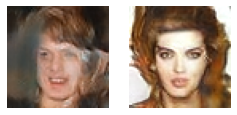

In [14]:
batch_size = 2
z = tf.random.normal((batch_size, style_gan.z_dim))
w = style_gan.mapping(z)
noise = style_gan.generate_noise(batch_size=batch_size)
images = style_gan.generate_images(style_code=w, noise=noise, alpha=1.)
plot_images(images, np.log2(64))

We can also mix styles from two images to create a new image.

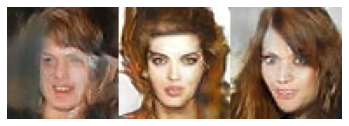

In [15]:
alpha = 0.5
w_mix = np.expand_dims(alpha*w[0] + (1 - alpha)*w[1], 0)
noise = style_gan.generate_noise(batch_size=1)
mix_images = style_gan.generate_images(style_code=w_mix, noise=noise)
image_row = np.hstack([images[0], images[1], mix_images[0]])
plt.imshow(image_row);
plt.axis('off');